In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=100)

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

In [5]:
api = wandb.Api()

## Playing around with loading the data from these runs

In [7]:
forgetting_exp_path = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited'
forgetting_exp_pattern = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited/{run_id}'
forgetting_runs = api.runs(forgetting_exp_path)

In [37]:
pilot_run_ids = ('1qbhftxs', '1p4n1uc7', '1qbhftxs', 
                 '1q4nh911', '50svhz73', '5eovveip',
                 'qlbfrpte', 'puam76u9', 'ubo2mvsa')

pilot_run_trajectories = [analysis.parse_forgetting_results(run_id) for run_id in pilot_run_ids]

Starting to parse run 1qbhftxs
Starting to parse run 1p4n1uc7
Starting to parse run 1qbhftxs
Starting to parse run 1q4nh911
Starting to parse run 50svhz73
Starting to parse run 5eovveip
Starting to parse run qlbfrpte
Starting to parse run puam76u9
Starting to parse run ubo2mvsa


In [38]:
stacked_trajectories = np.stack(pilot_run_trajectories)

max_first_nan = 0
for i in range(9):
    for j in range(10):
        for k in range(10):
            first_nan = np.isnan(stacked_trajectories[i,j,k]).argmax()
            if first_nan > max_first_nan:
                max_first_nan = first_nan
                
stacked_trajectories = stacked_trajectories[:,:,:,:max_first_nan]
stacked_trajectories.shape

(9, 10, 10, 421)

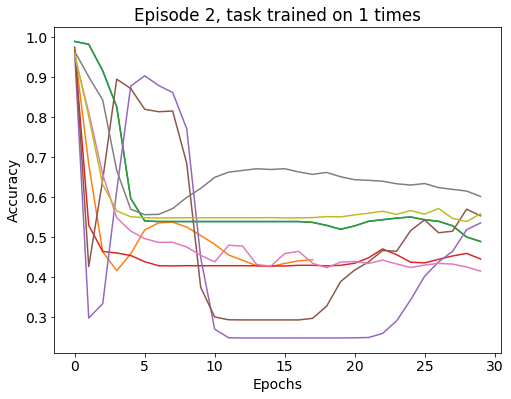

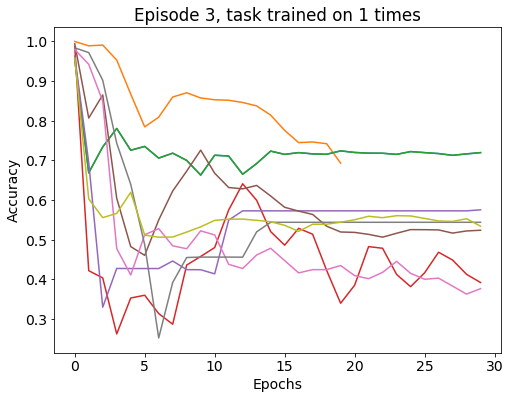

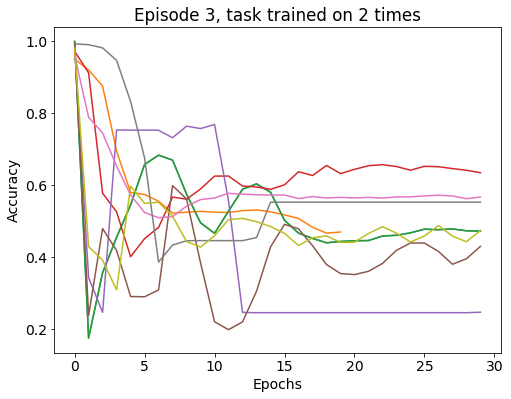

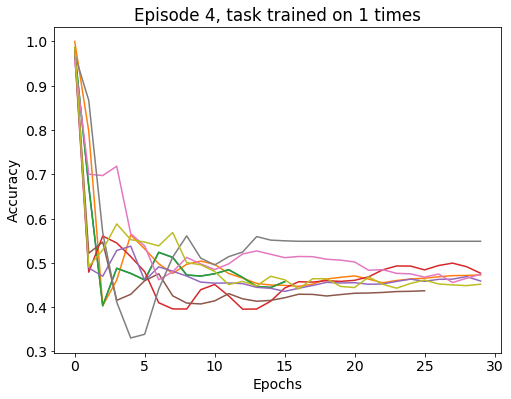

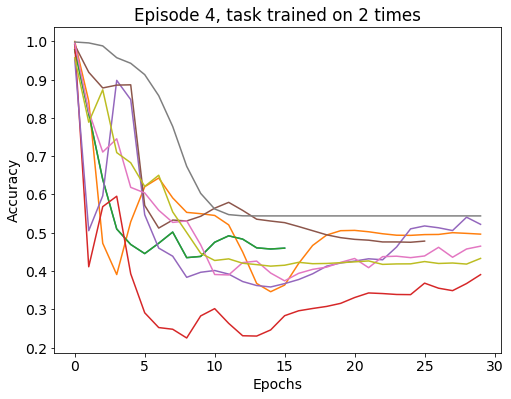

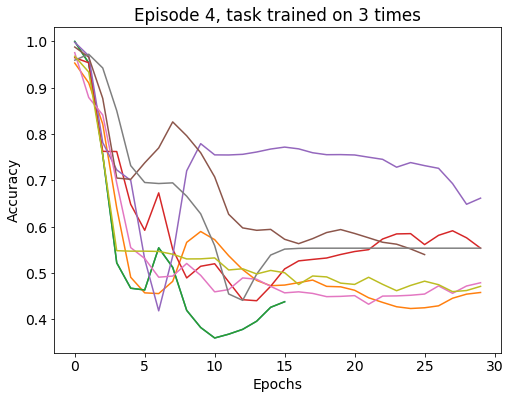

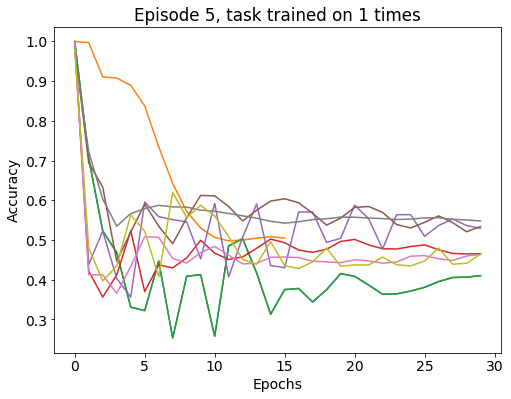

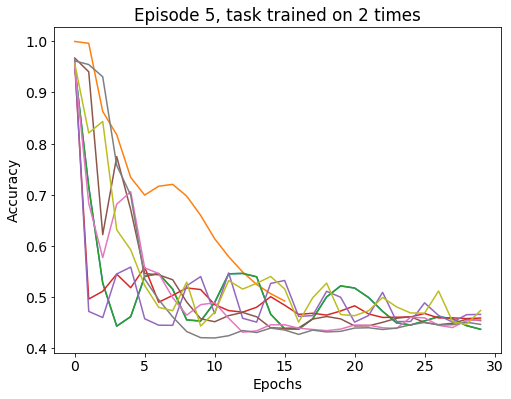

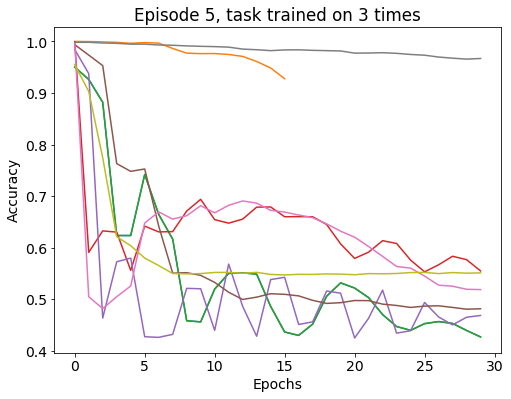

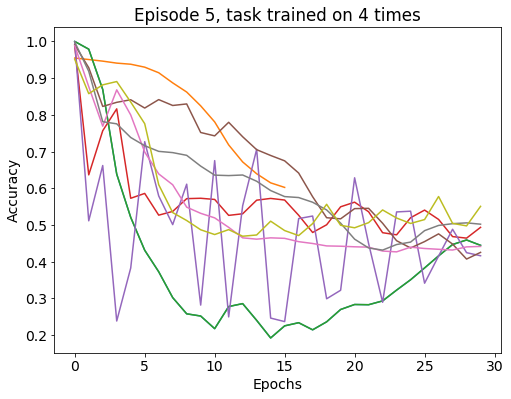

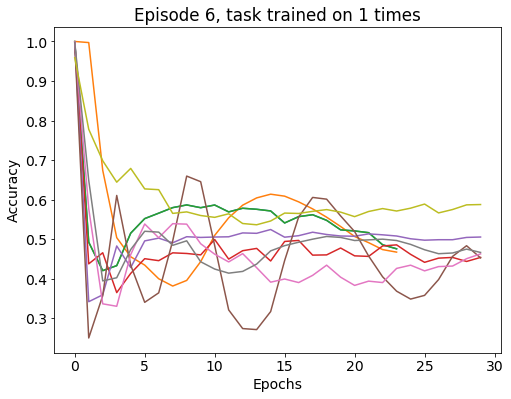

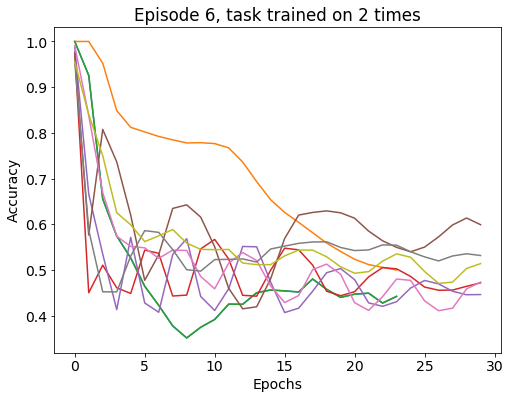

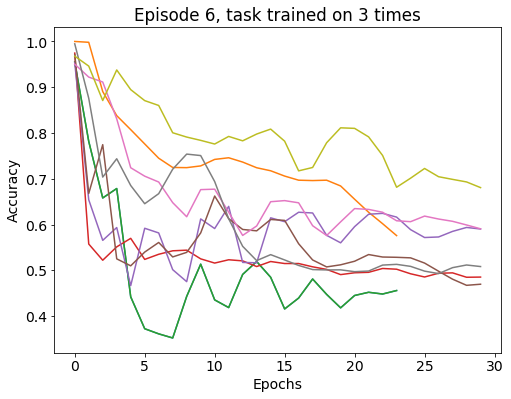

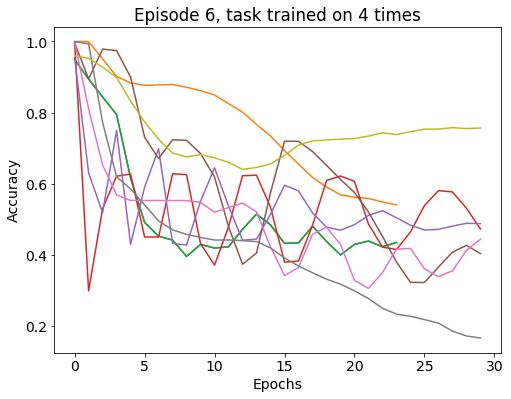

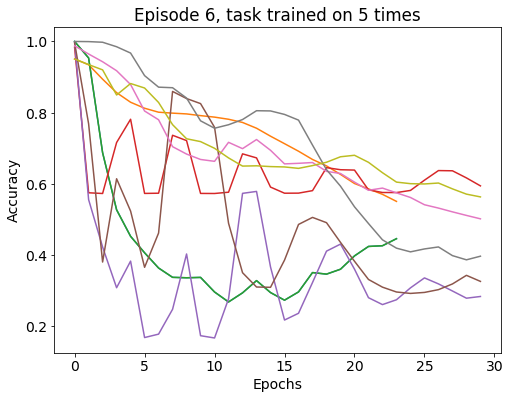

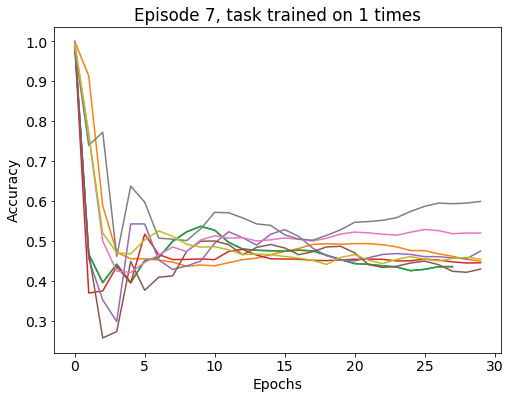

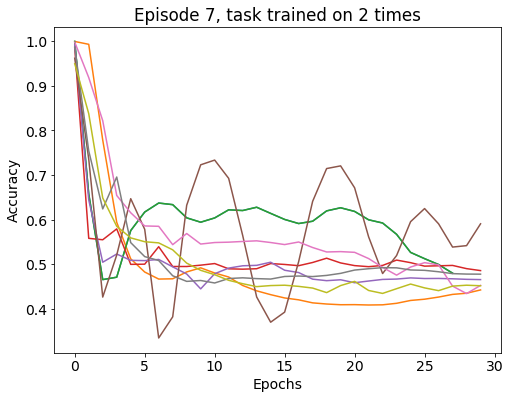

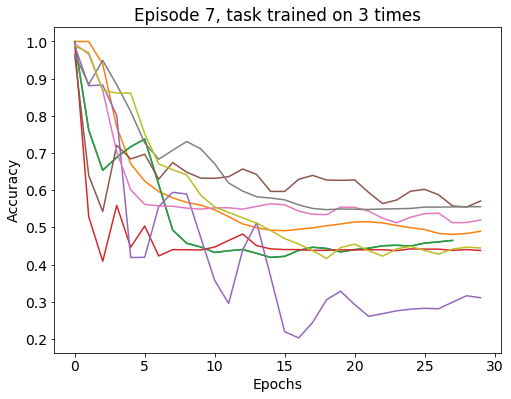

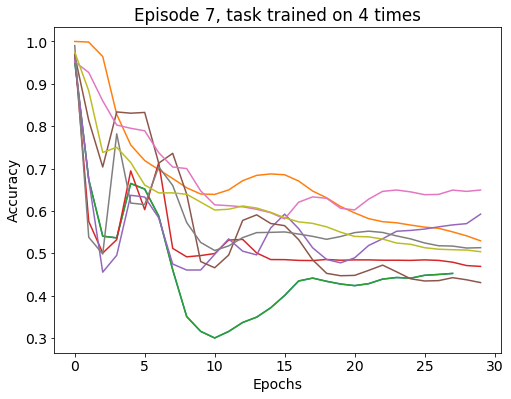

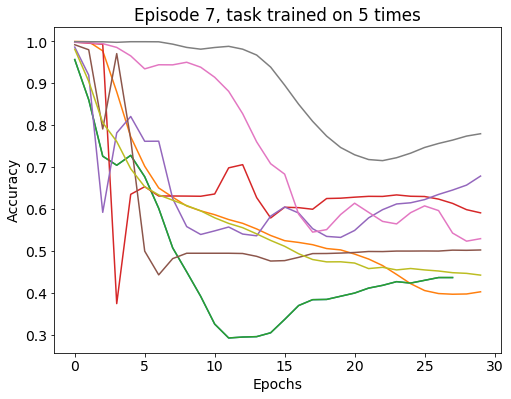

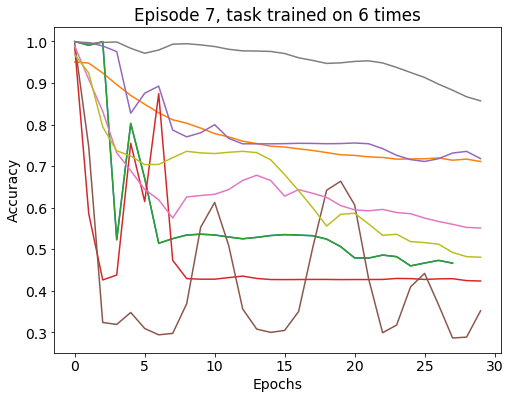

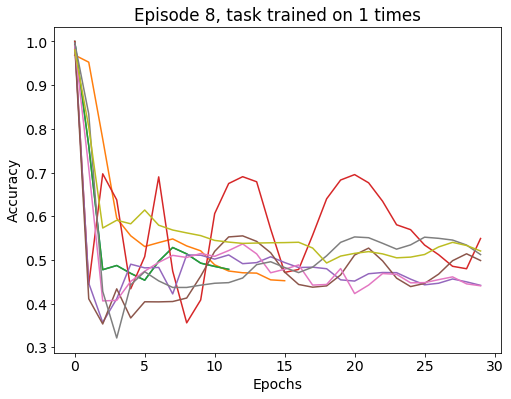

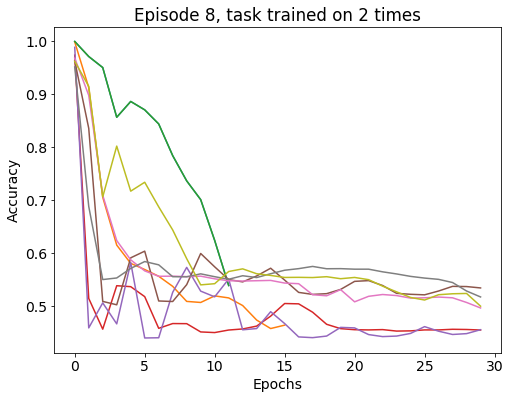

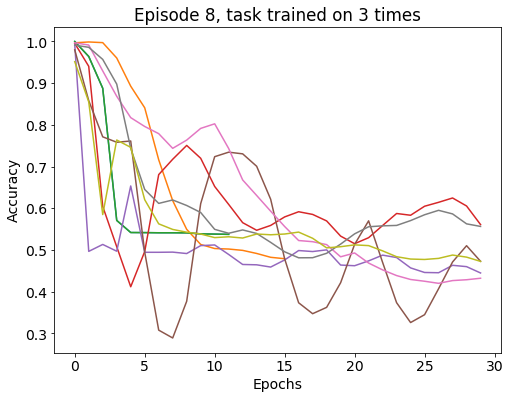

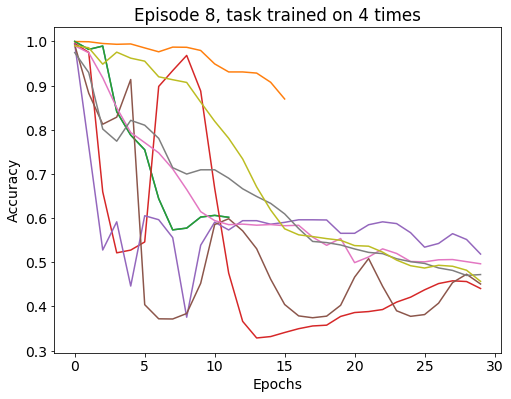

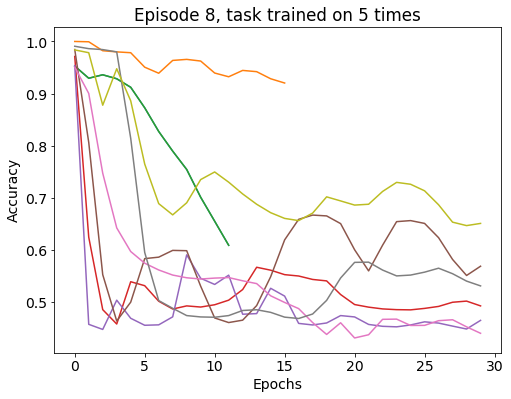

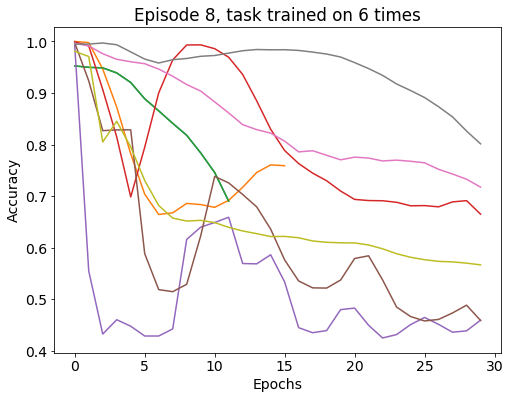

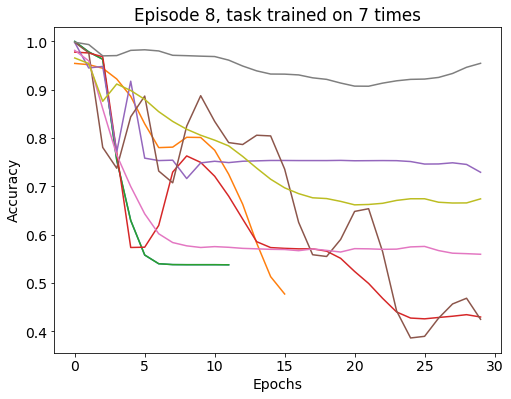

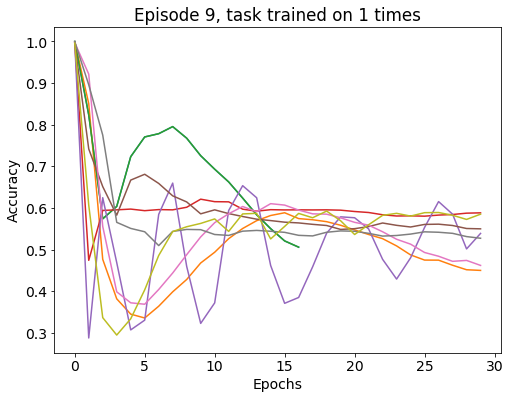

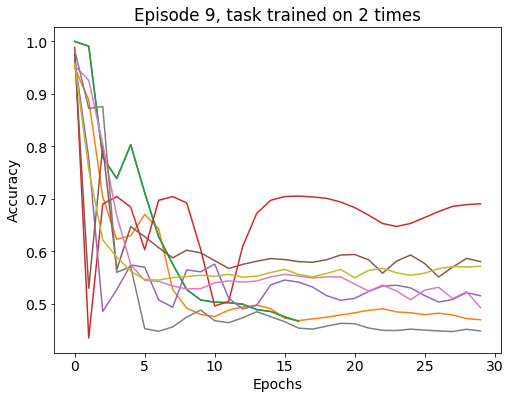

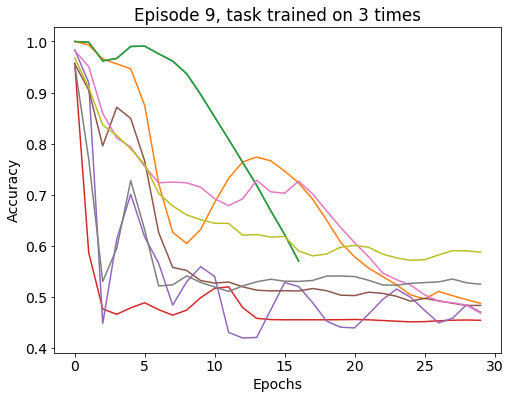

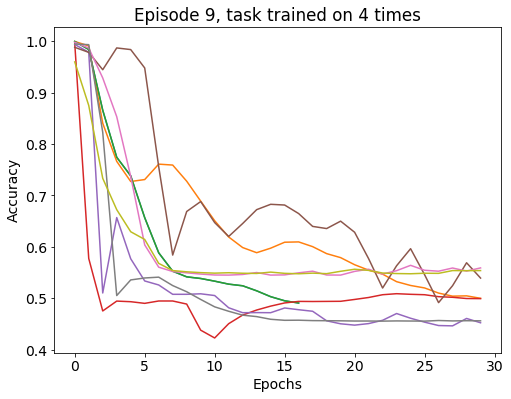

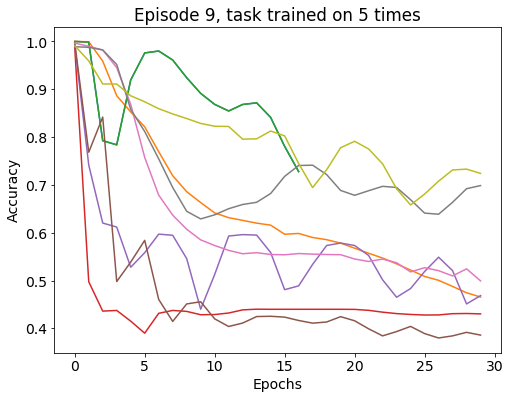

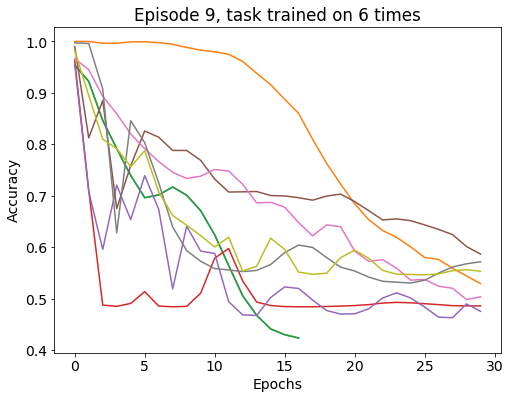

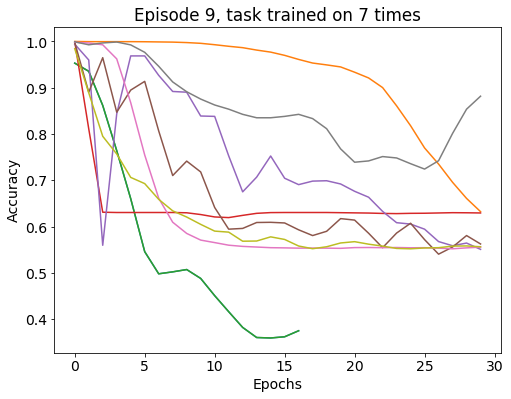

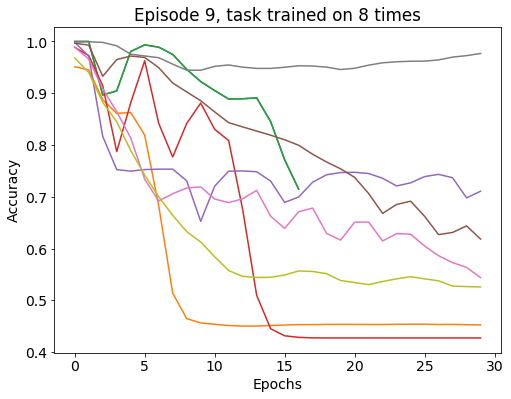

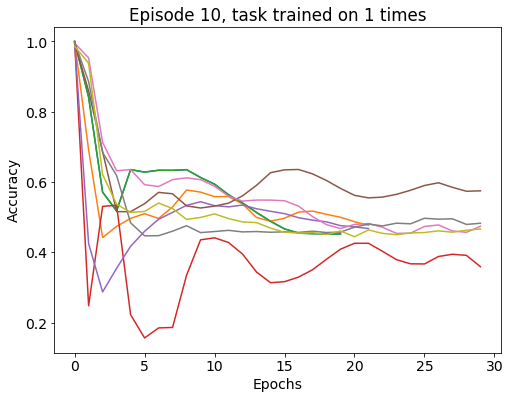

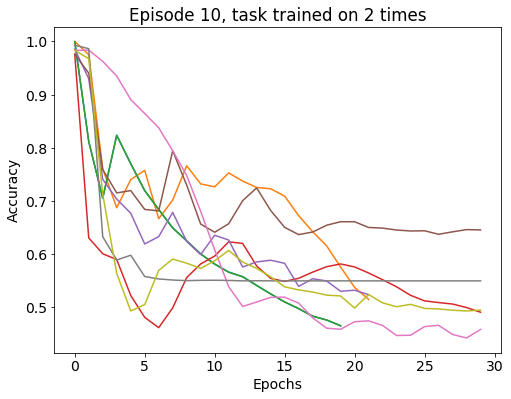

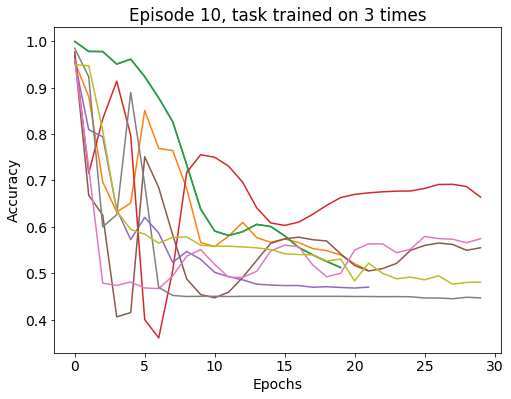

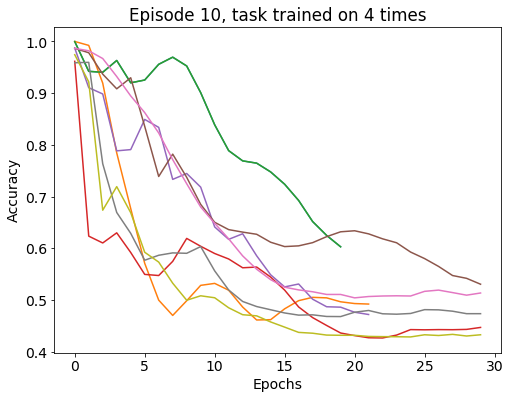

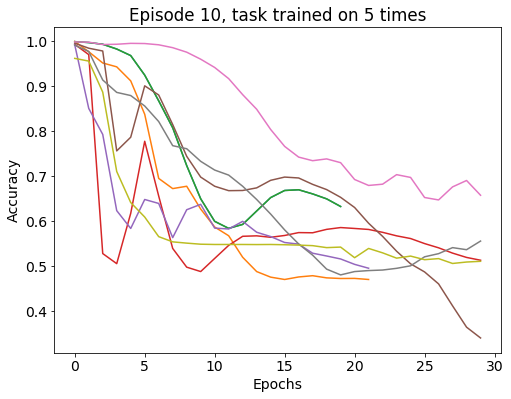

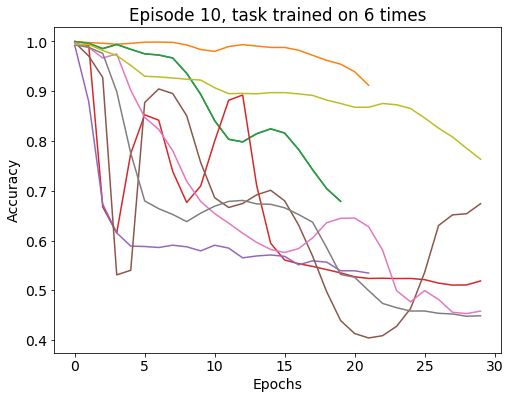

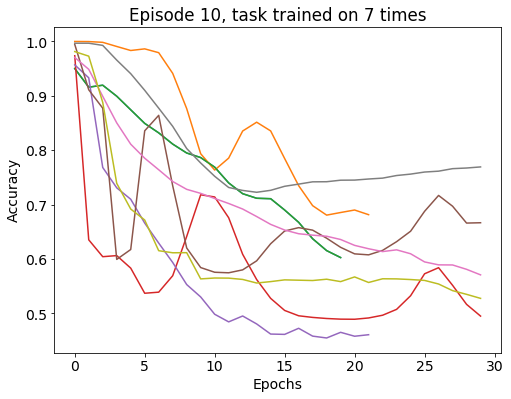

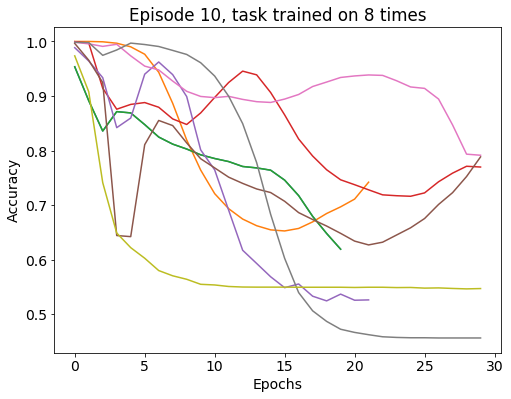

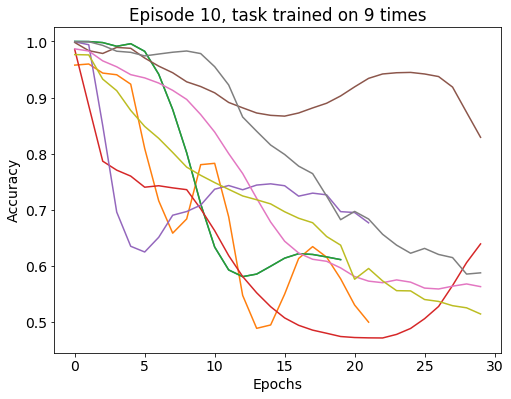

In [63]:
max_x = 30

for episode_num in range(10):
    for times_trained in range(10):
        is_nan = np.isnan(stacked_trajectories[:, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            for sample in range(9):
                data = stacked_trajectories[sample, times_trained, episode_num, :]
                nans = np.isnan(data)
                if not np.any(nans):
                    end = len(data)
                else:
                    end = nans.argmax()
                    
                end = min(max_x, end)
                plt.plot(data[:end])
            
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.show()



In [72]:
test_id = 'r6gc4st4'
r = api.run(forgetting_exp_pattern.format(run_id=test_id))

In [73]:
hist = r.history(samples=2000)

In [74]:
tasks_started = [f'Test Accuracy, Query #{current_task}' in hist for current_task in range(2, 11)]
first_valid

[True, True, True, True, True, False, False, False, False]

In [75]:
last_task = 2 + len(first_valid) - 1 - first_valid[::-1].index(True)
print(last_task)
hist[f'Test Accuracy, Query #{last_task}'].first_valid_index()

6


994

In [24]:
hist[hist[f'Test Accuracy, Query #{last_task}'].first_valid_index() - 1:]

,Test AUC,Test Accuracy,"Test Accuracy, Query #1","Test Accuracy, Query #2","Test Accuracy, Query #3","Test Accuracy, Query #4","Test Accuracy, Query #5","Test Accuracy, Query #6",Test Loss,Test Mean Previous-Query Accuracy,...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
993,0.988305,98.411765,0.9984,0.9998,0.9964,0.9990,0.9514,NaN,0.027859,0.99840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,0.879685,87.950000,0.9936,0.9894,0.9744,0.9598,0.9060,0.4710,0.379486,0.96464,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-3.224113702774048, -3.1338207721710...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.3103986978530884, -0.302613466978...","{'_type': 'histogram', 'values': [2, 1, 3, 2, ...","{'bins': [-0.036811329424381256, -0.0349721685...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [2, 4, 4, 4, 10, 7, 2, 2, 2, 4, 3, ..."
995,0.859347,85.450000,0.9944,0.9636,0.9470,0.8978,0.8054,0.5382,0.368197,0.92164,...,"{'values': [1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1...","{'_type': 'histogram', 'values': [4, 2, 1, 3, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 1, 1, ...","{'_type': 'histogram', 'values': [2, 2, 2, 3, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 4, 5, 6, ..."
996,0.835454,83.250000,0.9828,0.9642,0.9156,0.8342,0.7200,0.6078,0.443309,0.88336,...,"{'bins': [-0.29866403341293335, -0.28868597745...","{'_type': 'histogram', 'values': [2, 0, 2, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.6224260926246643, -0.599241554737...","{'_type': 'histogram', 'values': [3, 0, 1, 0, ...","{'_type': 'histogram', 'values': [12, 9, 7, 17...","{'_type': 'histogram', 'values': [2, 1, 7, 12,...","{'values': [1, 1, 0, 0, 0, 0, 0, 1, 3, 3, 7, 9...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ..."
997,0.797914,79.050000,0.9702,0.9492,0.8602,0.7316,0.6496,0.6070,0.601342,0.83216,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 2, 2, 2, ...","{'bins': [-0.20415134727954865, -0.19471676647...","{'_type': 'histogram', 'values': [3, 2, 2, 4, ...","{'_type': 'histogram', 'values': [2, 1, 2, 0, ...","{'values': [3, 3, 2, 0, 1, 1, 4, 7, 12, 14, 25...","{'_type': 'histogram', 'values': [3, 0, 1, 0, ...","{'_type': 'histogram', 'values': [3, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [4, 4, 8, 9, ..."
998,0.763516,76.250000,0.9480,0.9164,0.8120,0.6760,0.6036,0.6404,0.684784,0.79120,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 4, 1, 1, 3, 3, 6, 6, 6, 6, 9...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","{'bins': [-1.2460651397705078, -1.211212396621...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ..."
999,0.731491,73.850000,0.9244,0.8836,0.7570,0.6532,0.5596,0.6796,0.764131,0.75556,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 2, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1...","{'values': [1, 0, 0, 0, 0, 0, 1, 1, 5, 0, 0, 1...","{'_type': 'histogram', '

In [25]:
wandb.env.RESUME

'WANDB_RESUME'

In [36]:
cfg = r.file('config.yaml')

In [65]:
import yaml
import json

In [58]:
cfg_file = cfg.download(replace=True)
raw_cfg = cfg_file.read()

In [62]:
yaml.load(raw_cfg)


{'accuracy_threshold': {'desc': None, 'value': 0.95},
 'batch_size': {'desc': None, 'value': 1500},
 'benchmark_dimension': {'desc': None, 'value': 0},
 'dataset_random_seed': {'desc': None, 'value': 1053},
 'decay': {'desc': None, 'value': 0.0001},
 'epochs': {'desc': None, 'value': 1000},
 'loss': {'desc': None, 'value': 'CE'},
 'lr': {'desc': None, 'value': 0.0005},
 'original_run_id': {'desc': None, 'value': 'kyjvszri'},
 'query_order': {'desc': None, 'value': [2, 4, 7, 0, 5, 9, 8, 1, 3, 6]},
 'run_id_line_number': {'desc': None, 'value': 8},
 'test_coreset_size': {'desc': None, 'value': 5000},
 'train_sub_epoch_size': {'desc': None, 'value': 1500},
 'wandb_version': 1}

In [51]:
print(raw_cfg)

In [59]:
raw_cfg

'wandb_version: 1\n\naccuracy_threshold:\n  desc: null\n  value: 0.95\nbatch_size:\n  desc: null\n  value: 1500\nbenchmark_dimension:\n  desc: null\n  value: 0\ndataset_random_seed:\n  desc: null\n  value: 1053\ndecay:\n  desc: null\n  value: 0.0001\nepochs:\n  desc: null\n  value: 1000\nloss:\n  desc: null\n  value: CE\nlr:\n  desc: null\n  value: 0.0005\noriginal_run_id:\n  desc: null\n  value: kyjvszri\nquery_order:\n  desc: null\n  value:\n  - 2\n  - 4\n  - 7\n  - 0\n  - 5\n  - 9\n  - 8\n  - 1\n  - 3\n  - 6\nrun_id_line_number:\n  desc: null\n  value: 8\ntest_coreset_size:\n  desc: null\n  value: 5000\ntrain_sub_epoch_size:\n  desc: null\n  value: 1500\n'

In [70]:
c = json.loads(r.json_config)

In [71]:
len(c.keys())

14